In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import pickle

import h5py
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, TensorDataset, ConcatDataset, DataLoader
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

from sklearn.metrics import classification_report, f1_score, confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay, roc_curve, PrecisionRecallDisplay, precision_recall_curve, roc_auc_score
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt

In [ ]:
DATA_ROOT = '/content/drive/My Drive/Colab Notebooks/CSE6740_TeamProject/Data/Seq'
# DATA_ROOT = 'Data/Seq'

In [ ]:
SAVE_DIR = '/content/drive/My Drive/Colab Notebooks/CSE6740_TeamProject/Model'
# SAVE_DIR = 'Model'

In [ ]:
TRAIN_H5_PATH = os.path.join(DATA_ROOT, 'seq_uint8_0.h5')
VAL_H5_PATH = os.path.join(DATA_ROOT, 'seq_uint8_9.h5')
TEST1_H5_PATH = os.path.join(DATA_ROOT, 'seq_uint8_10.h5')
TEST2_H5_PATH = os.path.join(DATA_ROOT, 'seq_uint8_11.h5')

In [ ]:
TRAIN = True

In [ ]:
NUM_EPOCH = 200
EARLY_STOP = 10
SCALE_MODE = 'mixed'
MAX_LEN = 10
HIDDEN_SIZE = 256 # 64
BATCH_SIZE = 256
POS_WEIGHT = 47 # 35

In [ ]:
with open(os.path.join(DATA_ROOT, 'scale_params.pkl'), 'rb') as f:
    scale_params = pickle.load(f)

In [ ]:
np.random.seed(123)
torch.manual_seed(123)

use_cuda = torch.cuda.is_available()
use_mps = torch.backends.mps.is_available()

if use_cuda:
    device = torch.device("cuda")
elif use_mps:
    device = torch.device("mps")
else:
    device = torch.device("cpu")

In [ ]:
class H5Dataset(Dataset):
    def __init__(self, h5_path, scale_params, max_len=20, scale_mode='mixed', reverse=False):
        self.h5_path = h5_path
        self.max_len = max_len
        self.reverse = reverse

        if scale_mode == None:
            self.loc = 0
            self.scale = 1
        elif scale_mode == 'standard':
            self.loc = scale_params['mean']
            self.scale = scale_params['std']
        elif scale_mode == 'minmax':
            self.loc = scale_params['min']
            self.scale = scale_params['max'] - scale_params['min']
        elif scale_mode == 'mixed':
            columns = scale_params['columns']
            binary_features = scale_params['binary_features']
            integer_features = scale_params['integer_features']
            binary_mask = np.isin(columns, binary_features)
            integer_loc = scale_params['mean']
            integer_scale = scale_params['std']
            binary_loc = scale_params['min']
            binary_scale = scale_params['max'] - scale_params['min']
            self.loc = np.where(binary_mask, binary_loc, integer_loc)
            self.scale = np.where(binary_mask, binary_scale, integer_scale)
        else:
            raise NotImplementedError

        self.hf = None
        self.ids = None

        with h5py.File(self.h5_path, "r", libver='latest') as hf:
            self.ids = list(hf.keys())

    def __len__(self):
        return len(self.ids)

    def __getitem__(self, index):
        if self.hf is None:
            self.hf = h5py.File(self.h5_path, "r", libver='latest', swmr=True)

        data = self.hf.get(self.ids[index])
        features = np.asarray(data[-self.max_len:], dtype=np.float64)
        label = data.attrs["flag"]

        features -= self.loc.astype(np.float64)
        features /= self.scale.astype(np.float64)

        if self.reverse:
            features = np.flip(features, axis=0)

        return features, label

In [ ]:
def seq_collate_fn(batch):
    """
    DataLoaderIter call - self.collate_fn([self.dataset[i] for i in indices])
    Thus, 'batch' is a list [(seq1, label1), (seq2, label2), ... , (seqN, labelN)]
    where N is minibatch size, seq is a Numpy float32 array, and label is an integer

    :returns
        seqs
        labels
        lengths
    """
    batch_seq, batch_label = zip(*batch)
    num_features = batch_seq[0].shape[1]
    seq_lengths = list(map(lambda array: array.shape[0], batch_seq))
    max_length = max(seq_lengths)

    sorted_indices, sorted_lengths = zip(*sorted(enumerate(seq_lengths), key=lambda x: x[1], reverse=True))

    sorted_padded_seqs = []
    sorted_labels = []
    for i in sorted_indices:
        length = batch_seq[i].shape[0]

        if length < max_length:
            padded = np.concatenate(
                (batch_seq[i], np.zeros((max_length - length, num_features), dtype=batch_seq[i].dtype)), axis=0)
        else:
            padded = batch_seq[i]

        sorted_padded_seqs.append(padded)
        sorted_labels.append(batch_label[i])

    seq_tensor = torch.from_numpy(np.stack(sorted_padded_seqs, axis=0))
    label_tensor = torch.tensor(sorted_labels)
    length_tensor = torch.tensor(sorted_lengths)

    return seq_tensor, label_tensor, length_tensor

In [ ]:
class RNN(nn.Module):
    def __init__(self, input_size=59, hidden_size=64, num_layers=2, batch_first=True, dropout=0.5):
        super(RNN, self).__init__()
        self.batch_first = batch_first
        self.rnn = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=batch_first, dropout=dropout)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x, length):
        # x: (batch_size, max_len, feature_dim)
        packed_x = pack_padded_sequence(x, length, batch_first=self.batch_first, enforce_sorted=True)

        packed_rnn_out, (hn, cn) = self.rnn(packed_x)

        # unpacked_rnn_out: (batch_size, max_len, hidden_size)
        unpacked_rnn_out, unpacked_lengths = pad_packed_sequence(packed_rnn_out, batch_first=self.batch_first)

        # get the last output_t only
        last_step_idxs = torch.LongTensor([l-1 for l in unpacked_lengths]).to(unpacked_rnn_out.device)

        if self.batch_first:
            sample_idxs = torch.arange(unpacked_rnn_out.shape[0]).to(unpacked_rnn_out.device)
            last_rnn_out = unpacked_rnn_out[sample_idxs, last_step_idxs, :]
        else:
            sample_idxs = torch.arange(unpacked_rnn_out.shape[1]).to(unpacked_rnn_out.device)
            last_rnn_out = unpacked_rnn_out[last_step_idxs, sample_idxs, :]

        out = self.fc(last_rnn_out)

        return out

In [ ]:
def train(model, device, train_loader, criterion, optimizer, epoch):
    model.train()
    train_loss = 0
    train_count = 0
    for batch_idx, batch_data in enumerate(train_loader):
        data, target, length = batch_data
        data = data.float().to(device)
        target = target.float().to(device)
        # 'lengths' should be a 1D CPU int64 tensor

        optimizer.zero_grad()
        output = model(data, length)
        output = output.reshape(-1)
        loss = criterion(output, target)
        assert not np.isnan(loss.item()), 'Model diverged with loss = NaN'
        train_loss += loss.item()
        train_count += len(data)
        loss /= data.size(0)
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

    train_loss /= train_count
    return train_loss

In [ ]:
def test(model, device, test_loader, criterion):
    model.eval()
    test_loss = 0
    list_y_true = []
    list_y_score = []
    with torch.no_grad():
        for batch_data in test_loader:
            data, target, length = batch_data
            data = data.float().to(device)
            target = target.float().to(device)
            # 'lengths' should be a 1D CPU int64 tensor
            output = model(data, length)
            output = output.reshape(-1)
            test_loss += criterion(output, target).item()  # sum up batch loss

            list_y_true.extend(target.long().cpu().numpy().tolist())
            list_y_score.extend(torch.sigmoid(output).cpu().numpy().tolist())

    test_loss /= len(test_loader.dataset)
    auc = roc_auc_score(list_y_true, list_y_score)
    print('\nTest set: Average loss: {:.4f}, AUC: {:.4f}\n'.format(test_loss, auc))
    return test_loss, auc, list_y_true, list_y_score

In [ ]:
train_dataset = H5Dataset(TRAIN_H5_PATH, scale_params, max_len=MAX_LEN, scale_mode=SCALE_MODE)
val_dataset = H5Dataset(VAL_H5_PATH, scale_params, max_len=MAX_LEN, scale_mode=SCALE_MODE)
test_dataset = ConcatDataset([
    H5Dataset(TEST1_H5_PATH, scale_params, max_len=MAX_LEN, scale_mode=SCALE_MODE),
    H5Dataset(TEST2_H5_PATH, scale_params, max_len=MAX_LEN, scale_mode=SCALE_MODE)
])

In [ ]:
train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True, collate_fn=seq_collate_fn, num_workers=2)
val_loader = DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE, shuffle=False, drop_last=False, collate_fn=seq_collate_fn, num_workers=2)
test_loader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False, drop_last=False, collate_fn=seq_collate_fn, num_workers=2)

In [ ]:
model = RNN(hidden_size=HIDDEN_SIZE, batch_first=True).to(device)
optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-2)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=5, verbose=True)
criterion = nn.BCEWithLogitsLoss(reduction='sum', pos_weight=torch.tensor(POS_WEIGHT).to(device))

In [ ]:
if TRAIN:
    os.makedirs(SAVE_DIR, exist_ok=True)
    best_val_auc = 0.0
    early_stop_counter = 0
    train_losses = []
    val_losses = []
    for epoch in range(1, NUM_EPOCH + 1):
        train_loss = train(model, device, train_loader, criterion, optimizer, epoch)
        train_losses.append(train_loss)
        val_loss, val_auc, _, _ = test(model, device, val_loader, criterion)
        val_losses.append(val_loss)
        scheduler.step(val_auc)

        if val_auc > best_val_auc:
            print(f"New Best Validation AUC: {val_auc} at epoch {epoch}\n")
            torch.save(model.state_dict(), os.path.join(SAVE_DIR, "rnn.pth"))
            best_val_auc = val_auc
            early_stop_counter = 0
        else:
            early_stop_counter += 1

        if early_stop_counter == EARLY_STOP:
            break

# load the best model either it is train mode or not
model.load_state_dict(torch.load(os.path.join(SAVE_DIR, "rnn.pth")))

Train Epoch: 1 [0/250000 (0%)]	Loss: 1.816654
Train Epoch: 1 [25600/250000 (10%)]	Loss: 1.868887
Train Epoch: 1 [51200/250000 (20%)]	Loss: 1.183253
Train Epoch: 1 [76800/250000 (31%)]	Loss: 1.473170
Train Epoch: 1 [102400/250000 (41%)]	Loss: 1.173212
Train Epoch: 1 [128000/250000 (51%)]	Loss: 1.248742
Train Epoch: 1 [153600/250000 (61%)]	Loss: 1.229569
Train Epoch: 1 [179200/250000 (72%)]	Loss: 1.504976
Train Epoch: 1 [204800/250000 (82%)]	Loss: 1.193845
Train Epoch: 1 [230400/250000 (92%)]	Loss: 1.239420

Test set: Average loss: 1.5442, AUC: 0.6932

New Best Validation AUC: 0.6932442247451085 at epoch 1

Train Epoch: 2 [0/250000 (0%)]	Loss: 1.442430
Train Epoch: 2 [25600/250000 (10%)]	Loss: 1.270498
Train Epoch: 2 [51200/250000 (20%)]	Loss: 1.372891
Train Epoch: 2 [76800/250000 (31%)]	Loss: 1.523445
Train Epoch: 2 [102400/250000 (41%)]	Loss: 1.208283
Train Epoch: 2 [128000/250000 (51%)]	Loss: 1.445505
Train Epoch: 2 [153600/250000 (61%)]	Loss: 1.810585
Train Epoch: 2 [179200/250000 (7

<All keys matched successfully>

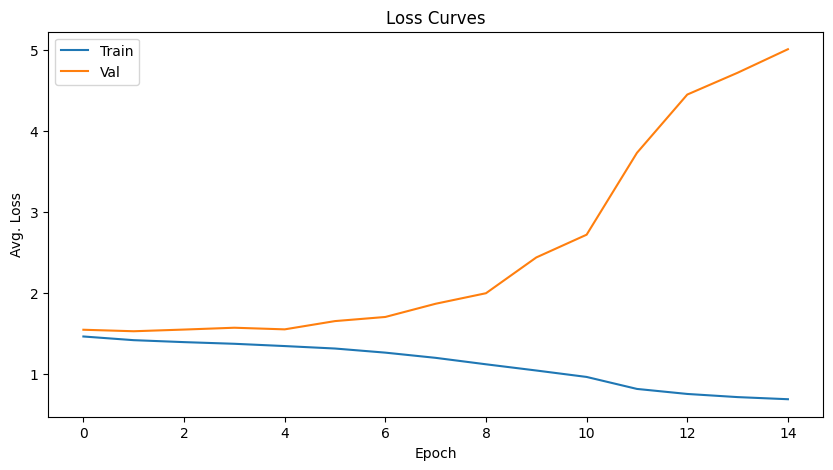

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.plot(train_losses, label='Train')
ax.plot(val_losses, label='Val')
ax.legend()
ax.set_xlabel('Epoch')
ax.set_ylabel('Avg. Loss')
ax.set_title('Loss Curves')
plt.show()

In [ ]:
test_loss, test_auc, y_test, y_score = test(model, device, test_loader, criterion)


Test set: Average loss: 1.5723, AUC: 0.6973



In [ ]:
y_score = np.array(y_score)
y_pred = (y_score > 0.5).astype(int)

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.61      0.75    483593
           1       0.06      0.68      0.10     16407

    accuracy                           0.61    500000
   macro avg       0.52      0.64      0.43    500000
weighted avg       0.95      0.61      0.73    500000



In [ ]:
f1_score(y_test, y_pred)

0.10242167592439826

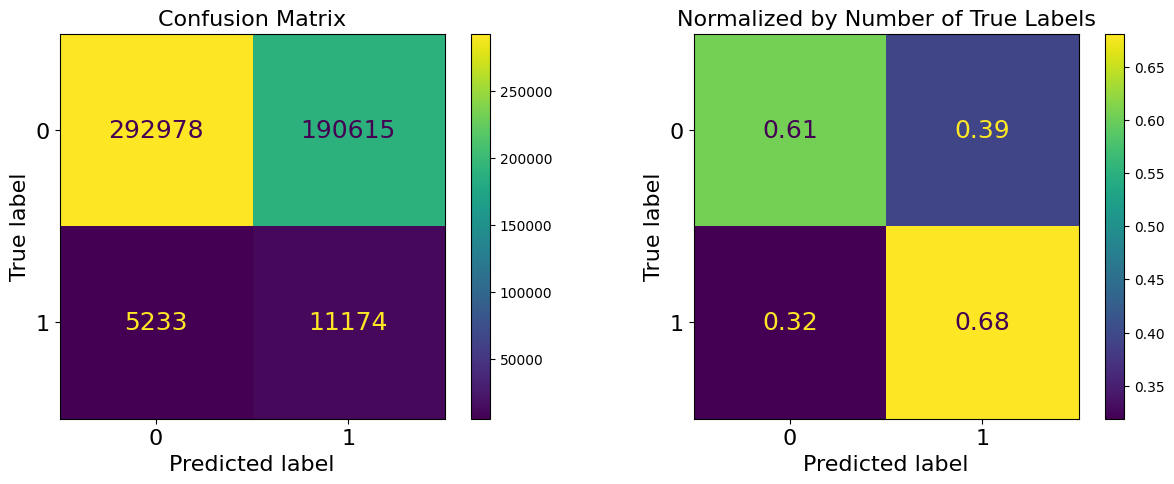

In [ ]:
fig1, (ax11, ax12) = plt.subplots(1, 2, figsize=(15, 5))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, ax=ax11, text_kw={'fontsize': 18})
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, normalize='true', ax=ax12, text_kw={'fontsize': 18})
ax11.set_title('Confusion Matrix', fontsize=16)
ax12.set_title('Normalized by Number of True Labels', fontsize=16)
ax11.xaxis.label.set_fontsize(16)
ax11.yaxis.label.set_fontsize(16)
ax11.tick_params(axis='both', which='major', labelsize=16)
ax12.xaxis.label.set_fontsize(16)
ax12.yaxis.label.set_fontsize(16)
ax12.tick_params(axis='both', which='major', labelsize=16)
plt.show()

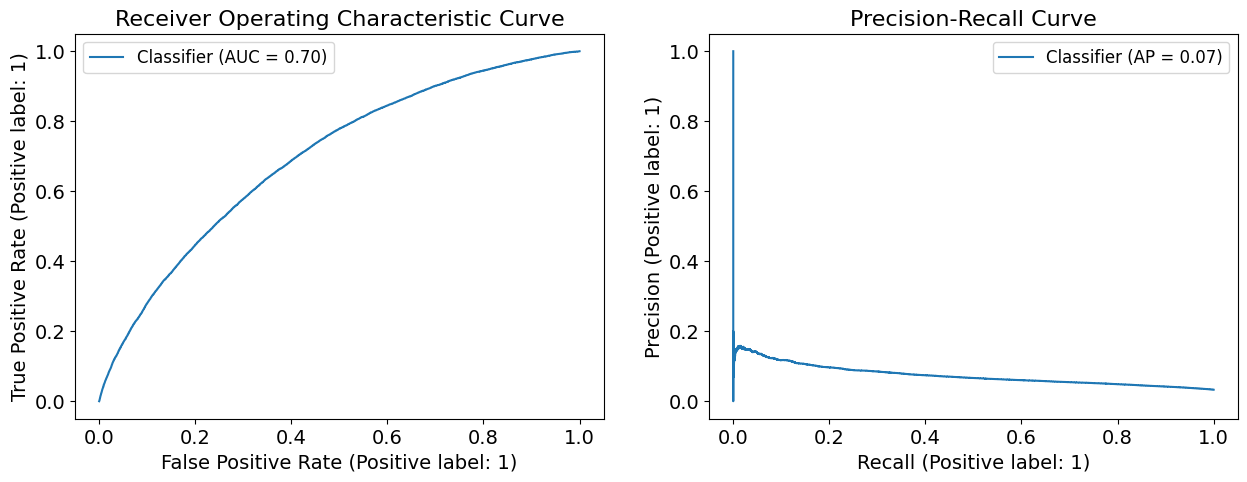

In [ ]:
fig2, (ax21, ax22) = plt.subplots(1, 2, figsize=(15, 5))
RocCurveDisplay.from_predictions(y_test, y_score, ax=ax21)
PrecisionRecallDisplay.from_predictions(y_test, y_score, ax=ax22)
ax21.set_title('Receiver Operating Characteristic Curve', fontsize=16)
ax21.xaxis.label.set_fontsize(14)
ax21.yaxis.label.set_fontsize(14)
ax21.tick_params(axis='both', which='major', labelsize=14)
ax21.legend(fontsize=12)
ax22.set_title('Precision-Recall Curve', fontsize=16)
ax22.xaxis.label.set_fontsize(14)
ax22.yaxis.label.set_fontsize(14)
ax22.tick_params(axis='both', which='major', labelsize=14)
ax22.legend(fontsize=12)
plt.show()